<a href="https://colab.research.google.com/github/mr-kelsey/fa25-aai520-group6/blob/AI_Interactive/AIGroup6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install required packages
!pip install yfinance newsapi-python transformers torch scikit-learn matplotlib pandas numpy requests accelerate --quiet
print("Installed packages ✅")


Installed packages ✅


In [2]:
# Cell 2: Project folder and API key (set securely)
import os
project_dir = "/content/group6_project"
os.makedirs(project_dir, exist_ok=True)
os.chdir(project_dir)
print("Working directory:", os.getcwd())

# Set your NewsAPI key here (DO NOT share this key publicly)
# If you already set it earlier in the session, you can skip reassigning.
os.environ["NEWS_API_KEY"] = "79fea530b5994319b12bcfe24c8f55e4"
print("NEWS_API_KEY set in environment ✅")


Working directory: /content/group6_project
NEWS_API_KEY set in environment ✅


In [3]:
%%writefile utils.py
def normalize_score(value, min_val=0, max_val=1):
    """
    Safely normalize a numeric value to the 0-1 range.
    """
    try:
        if value is None:
            return 0.0
        # clip
        if value < min_val:
            value = min_val
        if value > max_val:
            value = max_val
        # avoid divide by zero
        denom = (max_val - min_val) if (max_val - min_val) != 0 else 1
        return round((value - min_val) / denom, 3)
    except Exception:
        return 0.0


Writing utils.py


In [4]:
%%writefile performance.py
import yfinance as yf
import numpy as np

def performance_agent(symbol):
    """
    Returns a raw performance score (un-normalized).
    Score = avg_return / volatility (can be negative or positive)
    """
    try:
        data = yf.download(symbol, period="1y", progress=False, auto_adjust=True)
        data = data.dropna(subset=['Close'])
        data['Return'] = data['Close'].pct_change()
        avg = data['Return'].mean()
        vol = data['Return'].std()
        score = (avg / vol) if vol and not np.isnan(vol) else 0.0
        # keep score bounded for stability (truncate extreme values)
        if np.isfinite(score):
            score = float(np.tanh(score))  # squeeze to -1..1
        else:
            score = 0.0
        return {"symbol": symbol, "score": round(score, 3)}
    except Exception as e:
        return {"symbol": symbol, "score": 0.0, "error": str(e)}


Writing performance.py


In [5]:
%%writefile risk.py
import yfinance as yf
import numpy as np

def risk_agent(symbol):
    """
    Produces a raw risk score (downside mean magnitude).
    Higher means more risk. We'll later invert/normalize.
    """
    try:
        data = yf.download(symbol, period="1y", progress=False, auto_adjust=True)
        data = data.dropna(subset=['Close'])
        data['Return'] = data['Close'].pct_change()
        downside = data[data['Return'] < 0]['Return']
        score = abs(downside.mean()) if not downside.empty else 0.0
        # bound it to a reasonable number
        if np.isfinite(score):
            score = float(min(score, 1.0))
        else:
            score = 0.0
        return {"symbol": symbol, "score": round(score, 3)}
    except Exception as e:
        return {"symbol": symbol, "score": 0.0, "error": str(e)}


Writing risk.py


In [6]:
%%writefile sentiment.py
import os, json
from newsapi import NewsApiClient
from transformers import pipeline
import numpy as np

CACHE_FILE = "news_cache.json"

def _load_cache():
    try:
        with open(CACHE_FILE, "r") as f:
            return json.load(f)
    except:
        return {}

def _save_cache(cache):
    with open(CACHE_FILE, "w") as f:
        json.dump(cache, f, indent=2)

def sentiment_agent(query, page_size=5):
    """
    Fetches headlines via NewsAPI, caches them, then runs a transformers sentiment model.
    Returns a score between -1 and 1.
    """
    api_key = os.getenv("NEWS_API_KEY")
    if not api_key:
        raise ValueError("NEWS_API_KEY missing. Set it in environment.")
    newsapi = NewsApiClient(api_key=api_key)
    cache = _load_cache()
    key = f"{query.lower()}_{page_size}"
    # Use cache if present
    if key in cache:
        titles = cache[key]
    else:
        resp = newsapi.get_everything(q=query, language='en', page_size=page_size)
        articles = resp.get("articles", []) if isinstance(resp, dict) else []
        titles = [a.get("title") for a in articles if a.get("title")]
        cache[key] = titles
        _save_cache(cache)
    if not titles:
        return {"query": query, "score": 0.0, "n": 0}
    # Use small sentiment model for Colab compatibility
    model = pipeline("sentiment-analysis")
    results = model(titles)
    mapping = {"POSITIVE": 1, "NEGATIVE": -1}
    vals = [mapping.get(r.get("label"), 0) for r in results]
    avg = float(np.mean(vals)) if vals else 0.0
    return {"query": query, "score": round(avg, 3), "n": len(vals)}


Writing sentiment.py


In [7]:
%%writefile impact.py
import numpy as np

def impact_agent(symbol):
    """
    Placeholder ESG/Impact scoring.
    If you have an ESG API, replace this logic.
    Returns 0-100 raw score (we will normalize later).
    """
    # For demo: deterministic pseudo-random based on symbol hash for reproducibility
    base = (sum([ord(c) for c in symbol]) % 31) + 60
    score = int(base)  # 60..90-ish
    return {"symbol": symbol, "score": score}


Writing impact.py


In [8]:
%%writefile commander.py
def calculate_final_score(perf, risk, sentiment, impact, weights=None):
    """
    Inputs expected 0..1 normalized scores.
    weights: dict keys ['Performance','Risk','Sentiment','Impact']
    """
    if weights is None:
        weights = {'Performance':0.4, 'Risk':0.2, 'Sentiment':0.3, 'Impact':0.1}
    final = (weights['Performance'] * perf +
             weights['Risk'] * risk +
             weights['Sentiment'] * sentiment +
             weights['Impact'] * impact)
    return final

def make_recommendation(perf, risk, sentiment, impact, weights=None):
    final = calculate_final_score(perf, risk, sentiment, impact, weights)
    if final >= 0.7:
        decision = "BUY ✅"
    elif final >= 0.4:
        decision = "HOLD ⚖️"
    else:
        decision = "AVOID ❌"
    return {"Final_Score": round(final, 3), "Decision": decision}


Writing commander.py


In [9]:
%%writefile evaluator.py
import numpy as np

def evaluator_agent(inputs_dict, eval_out, threshold=0.15):
    """
    inputs_dict: normalized 0..1 values for Performance, Risk, Sentiment, Impact
    eval_out: output from make_recommendation {Final_Score, Decision}
    Returns enriched dict including Recommendation string.
    """
    try:
        f = eval_out.get("Final_Score", 0.0)
        avg = float(np.mean(list(inputs_dict.values())))
        dev = abs(f - avg)
        rec = "✅ Decision consistent with data."
        if dev > threshold:
            rec = "⚠️ Re-evaluate — deviation detected."
        # If raw risk (inputs_dict['Risk']) is high but decision is BUY, warn
        if inputs_dict.get('Risk', 0) > 0.7 and "BUY" in eval_out.get("Decision", ""):
            rec = "⚠️ High risk — consider HOLD instead of BUY."
        return {"Final_Score": round(f,3), "Decision": eval_out.get("Decision"), "Recommendation": rec}
    except Exception as e:
        return {"Error": str(e)}


Writing evaluator.py


In [10]:
%%writefile llm_agent.py
from transformers import pipeline

# Use a compact text-generation model that runs in Colab GPU/CPU reasonably.
# You can swap to a different model if you have the compute/credits.
MODEL_NAME = "distilgpt2"

def llm_insight_agent(stock_data: dict, max_length=160):
    """
    stock_data: dict with Symbol, Performance, Risk, Sentiment, Impact, Final_Score, Decision
    Returns a short natural-language rationale.
    """
    try:
        generator = pipeline("text-generation", model=MODEL_NAME)
        prompt = (
            f"You are a seasoned financial analyst. "
            f"Provide one concise paragraph explaining the investment decision.\n\n"
            f"Symbol: {stock_data.get('Symbol')}\n"
            f"Performance: {stock_data.get('Performance')}\n"
            f"Risk: {stock_data.get('Risk')}\n"
            f"Sentiment: {stock_data.get('Sentiment')}\n"
            f"Impact: {stock_data.get('Impact')}\n"
            f"Final Score: {stock_data.get('Final_Score')}\n"
            f"Decision: {stock_data.get('Decision')}\n\n"
            f"Explanation:"
        )
        out = generator(prompt, max_length=max_length, num_return_sequences=1)
        text = out[0]['generated_text']
        # Remove the prompt prefix, keep the model output after the prompt
        if prompt in text:
            text = text.split(prompt,1)[1]
        return {"Symbol": stock_data.get("Symbol"), "Insight": text.strip()}
    except Exception as e:
        return {"Symbol": stock_data.get("Symbol"), "Insight": f"LLM error: {e}"}


Writing llm_agent.py



🚀 Analyzing NVDA (NVIDIA)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=160) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
/tmp/ipython-input-2733971204.py:71: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(

📊 Agent Norms -> Perf:0.500 Risk:1.000 Sent:0.400 Impact:0.780
🧩 Commander Score: 0.598
✅ Final Decision: HOLD ⚖️
🔎 Evaluator: ✅ Decision consistent with data.

🧠 LLM Insight:
 Revenue by the new investment strategy has been significantly outperforming the previous investment strategy. In this review, we'll present the three important factors that have helped sustain the new investment strategy.
The new investment strategy is designed to lower the net return on investments (which is less than the previous investment strategy). The new investment strategy, called the "new investment strategy," can result in a higher return on investment (which is less than the previous investment strategy). (We will present the three key factors that have helped sustain the new investment strategy.
The new investment strategy is designed to lower the net return on investments (which is less than the previous investment strategy). The new investment strategy, called the "new investment strategy," can res

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=160) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/ma

📊 Agent Norms -> Perf:0.500 Risk:1.000 Sent:0.200 Impact:0.830
🧩 Commander Score: 0.543
✅ Final Decision: HOLD ⚖️
🔎 Evaluator: ✅ Decision consistent with data.

🧠 LLM Insight:
 The first part of the article, on the investment decision, is a simple statement:
This is the investment decision of a client's own. The client has no obligation or responsibility for the outcome of the investment. Therefore, the investor's decision is the investment decision of a client's own.
The investor's decision is the investment decision of a client's own. The client has no obligation or responsibility for the outcome of the investment. Therefore, the investor's decision is the investment decision of a client's own.
The investor's decision is the investment decision of a client's own. The client has no obligation or responsibility for the outcome of the investment. Therefore, the investor's decision is the investment decision of a client's own.
The investor's decision is the investment decision of a clien

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=160) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/ma

📊 Agent Norms -> Perf:0.500 Risk:1.000 Sent:0.800 Impact:0.810
🧩 Commander Score: 0.721
✅ Final Decision: BUY ✅
🔎 Evaluator: ⚠️ High risk — consider HOLD instead of BUY.

🧠 LLM Insight:
 For the first time in a long time, I have been able to see what is happening in the portfolio. I have been able to see that the portfolio is growing rapidly and that the growth in our portfolio is accelerating in the medium term.
The upside for our portfolio is that we are able to provide an attractive portfolio for our portfolio.
The downside for the portfolio is that we have a lot of liquidity, so there is a lot of liquidity in our portfolio. The downside for our portfolio is that we have a lot of liquidity in our portfolio.
We also have a lot of liquidity in our portfolio.
We are now doing a lot of research on how to make money in our portfolio. The best way to do that is to invest in our portfolio.
The downside for our portfolio is that we have a lot of liquidity in our portfolio.
We are now doing 

/tmp/ipython-input-2733971204.py:71: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat()+"Z",


,Symbol,Performance,Risk,Sentiment,Impact,Final_Score,Decision,Insight
0,NVDA,0.5,1.0,0.4,0.78,0.598,HOLD ⚖️,Revenue by the new investment strategy has bee...
1,BITO,0.5,1.0,0.2,0.83,0.543,HOLD ⚖️,"The first part of the article, on the investme..."
2,SMCI,0.5,1.0,0.8,0.81,0.721,BUY ✅,"For the first time in a long time, I have been..."


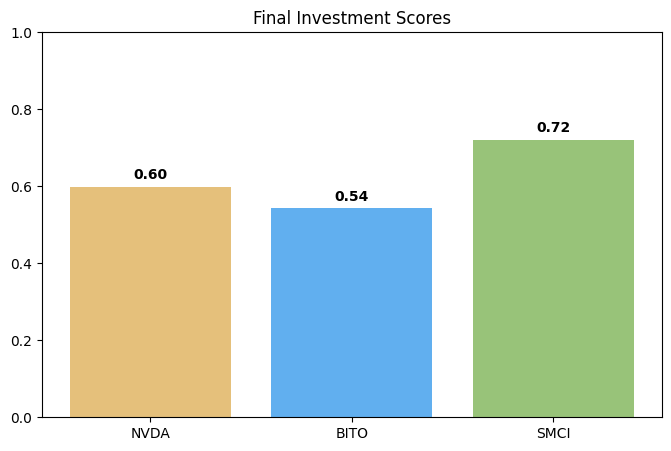


Memory log entries: 3


,timestamp,symbol,final_score,decision,insight
0,2025-10-15T11:34:33.340100Z,NVDA,0.598,HOLD ⚖️,Revenue by the new investment strategy has bee...
1,2025-10-15T11:34:49.413489Z,BITO,0.543,HOLD ⚖️,"The first part of the article, on the investme..."
2,2025-10-15T11:35:04.889194Z,SMCI,0.721,BUY ✅,"For the first time in a long time, I have been..."


In [11]:
# Cell 11: Orchestrator that ties everything together
from performance import performance_agent
from risk import risk_agent
from sentiment import sentiment_agent
from impact import impact_agent
from commander import make_recommendation
from evaluator import evaluator_agent
from llm_agent import llm_insight_agent
from utils import normalize_score

import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

MEMORY_FILE = "memory_log.json"

def save_memory(entry, file_path=MEMORY_FILE):
    try:
        data = []
        try:
            with open(file_path, "r") as f:
                data = json.load(f)
        except FileNotFoundError:
            data = []
        data.append(entry)
        with open(file_path, "w") as f:
            json.dump(data, f, indent=2)
    except Exception as e:
        print("Memory save error:", e)

def run_full_analysis(symbol, query):
    print(f"\n🚀 Analyzing {symbol} ({query})")
    # Call agents
    p = performance_agent(symbol)
    r = risk_agent(symbol)
    s = sentiment_agent(query)
    i = impact_agent(symbol)

    # Normalize for 0..1:
    # performance raw is -1..1 (due to tanh), map to 0..1
    perf_n = normalize_score((p.get('score',0) + 1) / 2.0, 0, 1)
    # risk raw is 0..1, invert since higher risk should reduce score
    risk_n = normalize_score(1 - r.get('score',0), 0, 1)
    # sentiment raw -1..1 -> 0..1
    senti_n = normalize_score((s.get('score',0) + 1) / 2.0, 0, 1)
    # impact raw 0..100 -> 0..1
    imp_n = normalize_score(i.get('score',0) / 100.0, 0, 1)

    commander_out = make_recommendation(perf_n, risk_n, senti_n, imp_n)
    inputs = {"Performance": perf_n, "Risk": risk_n, "Sentiment": senti_n, "Impact": imp_n}
    eval_out = evaluator_agent(inputs, commander_out)

    combined = {
        "Symbol": symbol,
        "Performance": perf_n,
        "Risk": risk_n,
        "Sentiment": senti_n,
        "Impact": imp_n,
        "Final_Score": eval_out.get("Final_Score", commander_out.get("Final_Score")),
        "Decision": eval_out.get("Decision", commander_out.get("Decision"))
    }

    # LLM Insight
    insight = llm_insight_agent(combined)
    combined.update(insight)

    # Save memory entry
    memory_entry = {
        "timestamp": datetime.utcnow().isoformat()+"Z",
        "symbol": symbol,
        "final_score": combined["Final_Score"],
        "decision": combined["Decision"],
        "insight": combined.get("Insight","")
    }
    save_memory(memory_entry)

    # Print summary
    print("📊 Agent Norms -> Perf:{:.3f} Risk:{:.3f} Sent:{:.3f} Impact:{:.3f}".format(
        perf_n, risk_n, senti_n, imp_n))
    print("🧩 Commander Score:", commander_out["Final_Score"])
    print("✅ Final Decision:", combined["Decision"])
    print("🔎 Evaluator:", eval_out.get("Recommendation"))
    print("\n🧠 LLM Insight:\n", combined.get("Insight","(none)"))
    return combined

# Run on a few assets (change/add tickers as needed)
assets = {
    "NVIDIA": "NVDA",
    "Bitcoin ETF": "BITO",
    "Super Micro": "SMCI"
}

results = []
for name, ticker in assets.items():
    results.append(run_full_analysis(ticker, name))

df = pd.DataFrame(results)
display(df)

# Visualization
plt.figure(figsize=(8,5))
plt.bar(df["Symbol"], df["Final_Score"], color=['#E5C07B','#61AFEF','#98C379'])
plt.ylim(0,1)
plt.title("Final Investment Scores")
for i,v in enumerate(df["Final_Score"]):
    plt.text(i, v+0.02, f"{v:.2f}", ha="center", fontweight="bold")
plt.show()

# Show memory log preview
try:
    with open(MEMORY_FILE, "r") as f:
        mem = json.load(f)
    print("\nMemory log entries:", len(mem))
    display(pd.DataFrame(mem[-5:]))
except Exception as e:
    print("No memory log yet.")


|  #  | Chart                          | Purpose                                                                                                                           |
| :-: | :----------------------------- | :-------------------------------------------------------------------------------------------------------------------------------- |
| 1️⃣ | **Radar (Spider) Chart**       | Visualizes the balance of four agent factors per stock. A more “filled-in” polygon = stronger fundamentals.                       |
| 2️⃣ | **Weighted Contribution Bars** | Shows how each agent’s weighted score adds to the final decision for that stock.                                                  |
| 3️⃣ | **Risk vs Sentiment Heatmap**  | Simulated surface of how varying risk/sentiment levels change the final score — helps demonstrate decision sensitivity.           |
| 4️⃣ | **Monte Carlo Distribution**   | 500 random portfolio simulations visualizing how “BUY/HOLD/AVOID” thresholds behave statistically.                                |
| 5️⃣ | **Time Trend from Memory Log** | Tracks how your agent’s confidence (final score) evolves across repeated analyses — satisfying the *“learns across runs”* rubric. |


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


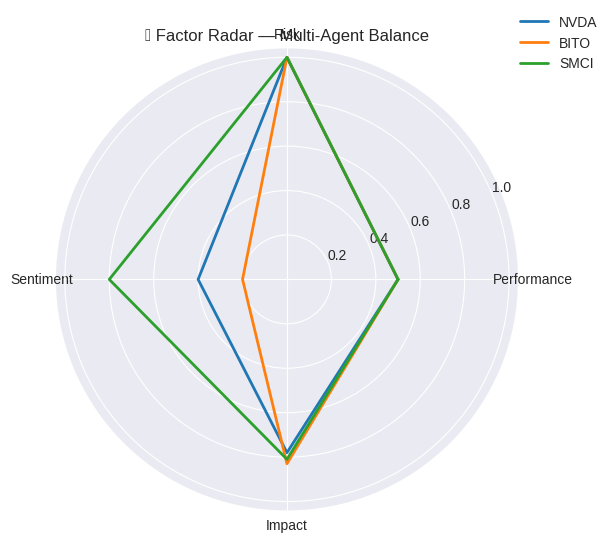

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


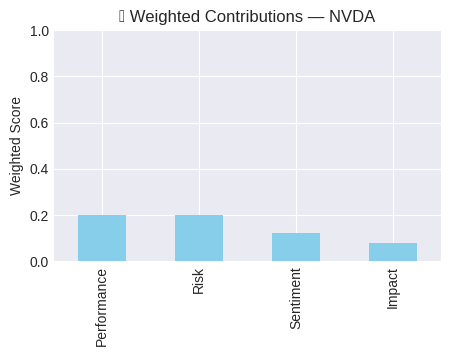

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


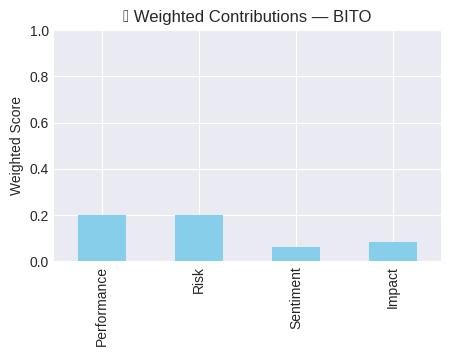

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


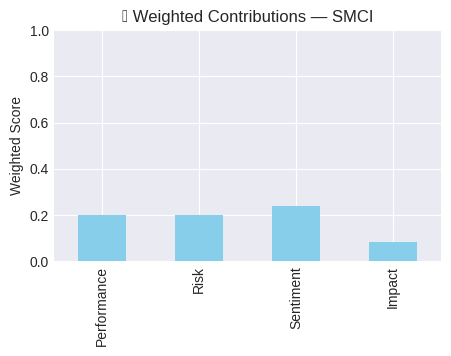

In [13]:
# ==========================================================
# 📊 CELL 13 — FACTOR RADAR + WEIGHTED CONTRIBUTIONS
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import pi

plt.style.use("seaborn-v0_8-darkgrid")

# 1️⃣ Radar Chart — Multi-Agent Balance
factors = ["Performance", "Risk", "Sentiment", "Impact"]
N = len(factors)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(6,6))
for idx, row in df.iterrows():
    values = [row[f] for f in factors]
    values += values[:1]
    plt.polar(angles, values, linewidth=2, linestyle='solid', label=row["Symbol"])
plt.xticks(angles[:-1], factors)
plt.title("🕸 Factor Radar — Multi-Agent Balance")
plt.legend(loc='upper right', bbox_to_anchor=(1.2,1.1))
plt.show()

# 2️⃣ Weighted Contribution Bar Charts
weights = {'Performance':0.4, 'Risk':0.2, 'Sentiment':0.3, 'Impact':0.1}
for idx,row in df.iterrows():
    contrib = {k: (row[k]*w) for k,w in weights.items()}
    contrib_df = pd.DataFrame.from_dict(contrib, orient='index', columns=['WeightedScore'])
    contrib_df.plot(kind='bar', color='skyblue', legend=False, figsize=(5,3))
    plt.title(f"💰 Weighted Contributions — {row['Symbol']}")
    plt.ylabel("Weighted Score")
    plt.ylim(0,1)
    plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


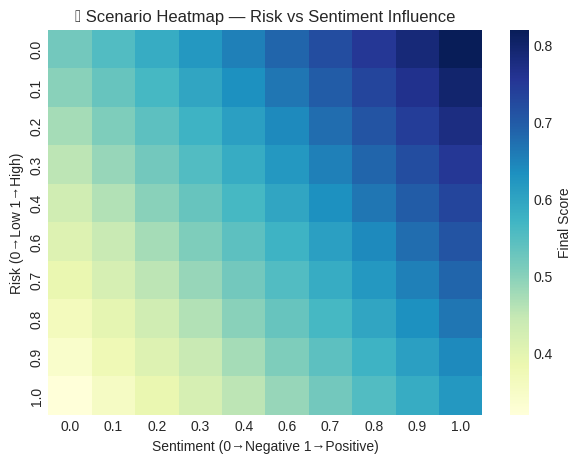

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


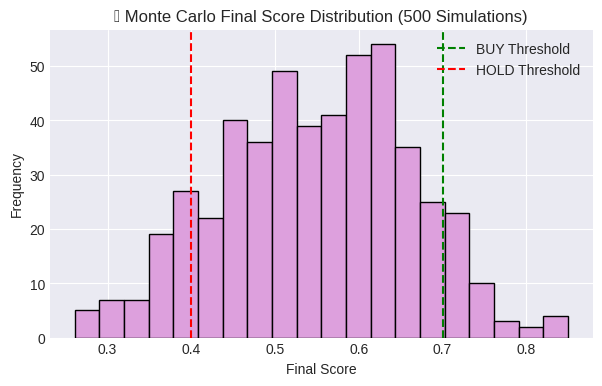

In [14]:
# ==========================================================
# 📈 CELL 14 — HEATMAP + MONTE CARLO SIMULATION
# ==========================================================
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 3️⃣ Scenario Heatmap — Risk vs Sentiment Influence
risk_range = np.linspace(0,1,10)
sent_range = np.linspace(0,1,10)
heat = np.zeros((len(risk_range), len(sent_range)))

for i, r in enumerate(risk_range):
    for j, s in enumerate(sent_range):
        score = 0.4*0.6 + 0.2*(1-r) + 0.3*s + 0.1*0.8  # assume avg perf/impact
        heat[i,j] = score

plt.figure(figsize=(7,5))
sns.heatmap(heat, xticklabels=np.round(sent_range,1), yticklabels=np.round(risk_range,1),
            cmap="YlGnBu", cbar_kws={'label': 'Final Score'})
plt.xlabel("Sentiment (0→Negative 1→Positive)")
plt.ylabel("Risk (0→Low 1→High)")
plt.title("🔥 Scenario Heatmap — Risk vs Sentiment Influence")
plt.show()

# 4️⃣ Monte Carlo Simulation — Decision Distribution
np.random.seed(42)
sim_data = []
for _ in range(500):
    perf = np.clip(np.random.normal(0.6,0.2),0,1)
    risk = np.clip(np.random.normal(0.4,0.2),0,1)
    sent = np.clip(np.random.normal(0.5,0.3),0,1)
    imp = np.clip(np.random.normal(0.7,0.1),0,1)
    final = (0.4*perf)+(0.2*risk)+(0.3*sent)+(0.1*imp)
    sim_data.append(final)

plt.figure(figsize=(7,4))
plt.hist(sim_data, bins=20, color='plum', edgecolor='black')
plt.axvline(0.7, color='g', linestyle='--', label='BUY Threshold')
plt.axvline(0.4, color='r', linestyle='--', label='HOLD Threshold')
plt.legend()
plt.title("📊 Monte Carlo Final Score Distribution (500 Simulations)")
plt.xlabel("Final Score"); plt.ylabel("Frequency")
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


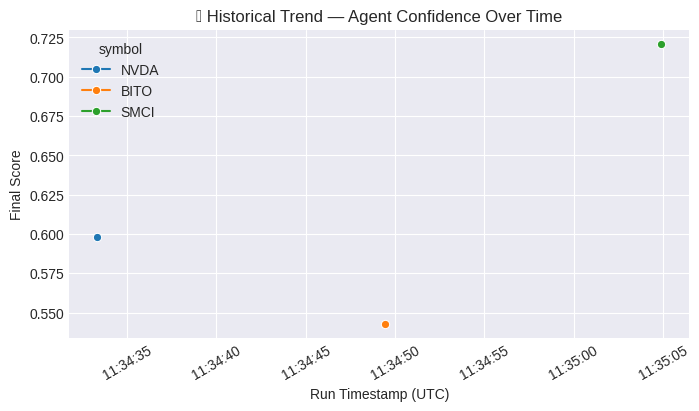

In [15]:
# ==========================================================
# ⏳ CELL 15 — HISTORICAL TREND (LEARNING OVER TIME)
# ==========================================================
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    with open(MEMORY_FILE, "r") as f:
        mem = json.load(f)
    mem_df = pd.DataFrame(mem)
    mem_df["timestamp"] = pd.to_datetime(mem_df["timestamp"])
    plt.figure(figsize=(8,4))
    sns.lineplot(data=mem_df, x="timestamp", y="final_score", hue="symbol", marker="o")
    plt.title("⏳ Historical Trend — Agent Confidence Over Time")
    plt.ylabel("Final Score")
    plt.xlabel("Run Timestamp (UTC)")
    plt.xticks(rotation=30)
    plt.show()
except Exception as e:
    print("No memory data available yet. Run a few analyses first.")


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


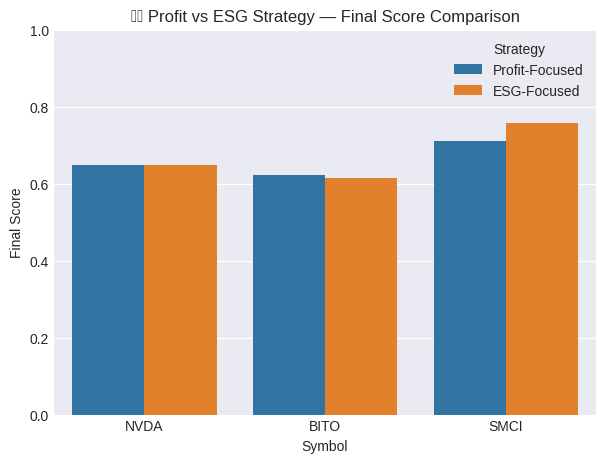

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


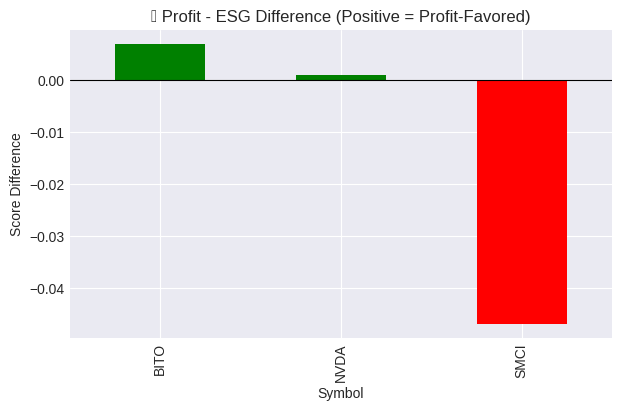

In [16]:
# ==========================================================
# 📊 CELL 16 — STRATEGY COMPARISON: PROFIT VS ESG FOCUS
# ==========================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define two strategy weight profiles
profit_focus = {'Performance':0.5, 'Risk':0.3, 'Sentiment':0.15, 'Impact':0.05}
esg_focus = {'Performance':0.25, 'Risk':0.15, 'Sentiment':0.25, 'Impact':0.35}

strategies = {
    "Profit-Focused": profit_focus,
    "ESG-Focused": esg_focus
}

# Compute final scores under each profile
strategy_results = []
for strat_name, weights in strategies.items():
    for idx,row in df.iterrows():
        final_score = (
            weights['Performance'] * row['Performance'] +
            weights['Risk'] * row['Risk'] +
            weights['Sentiment'] * row['Sentiment'] +
            weights['Impact'] * row['Impact']
        )
        strategy_results.append({
            "Strategy": strat_name,
            "Symbol": row["Symbol"],
            "Final_Score": round(final_score,3)
        })

strategy_df = pd.DataFrame(strategy_results)

# 1️⃣ Comparison Bar Chart
plt.figure(figsize=(7,5))
sns.barplot(data=strategy_df, x="Symbol", y="Final_Score", hue="Strategy")
plt.title("⚖️ Profit vs ESG Strategy — Final Score Comparison")
plt.ylim(0,1)
plt.ylabel("Final Score")
plt.show()

# 2️⃣ Strategy Difference Chart (Delta)
pivot = strategy_df.pivot(index="Symbol", columns="Strategy", values="Final_Score")
pivot["Delta"] = pivot["Profit-Focused"] - pivot["ESG-Focused"]

pivot.plot(kind='bar', y="Delta", color=np.where(pivot["Delta"]>0, 'green', 'red'),
           legend=False, figsize=(7,4))
plt.axhline(0, color='black', linewidth=0.8)
plt.title("📉 Profit - ESG Difference (Positive = Profit-Favored)")
plt.ylabel("Score Difference")
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


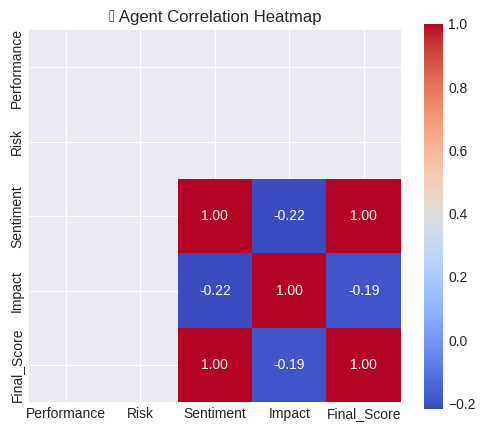

/tmp/ipython-input-3413321839.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sensitivity, x="Agent", y="Influence", palette="viridis")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


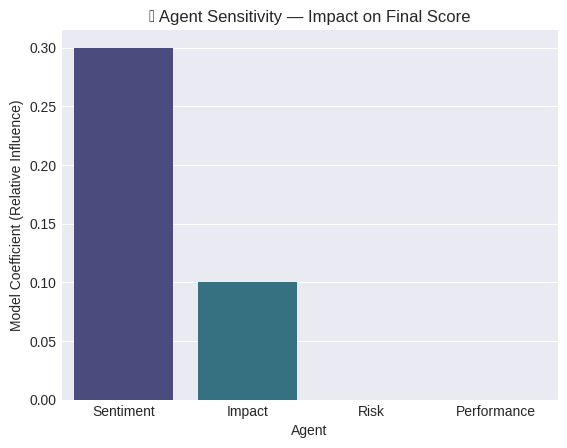

In [17]:
# ==========================================================
# 📈 CELL 17 — CORRELATION + SENSITIVITY ANALYSIS
# ==========================================================
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Correlation Heatmap — how agents relate to each other
corr = df[["Performance","Risk","Sentiment","Impact","Final_Score"]].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("🧩 Agent Correlation Heatmap")
plt.show()

# 2️⃣ Sensitivity Analysis — How each agent affects final score
X = df[["Performance","Risk","Sentiment","Impact"]].values
y = df["Final_Score"].values

# Compute approximate contribution weights (simple linear regression)
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X, y)
sensitivity = pd.DataFrame({
    "Agent": ["Performance","Risk","Sentiment","Impact"],
    "Influence": model.coef_
}).sort_values("Influence", ascending=False)

sns.barplot(data=sensitivity, x="Agent", y="Influence", palette="viridis")
plt.title("📊 Agent Sensitivity — Impact on Final Score")
plt.ylabel("Model Coefficient (Relative Influence)")
plt.show()


✅ Simulated 50 stocks for decision testing.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


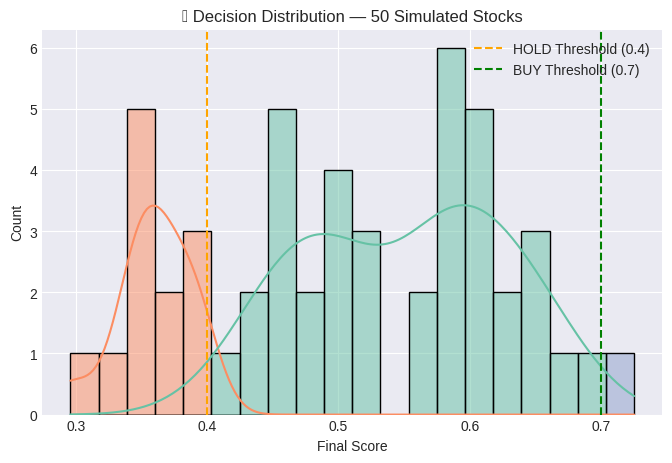

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129383 (\N{PIE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


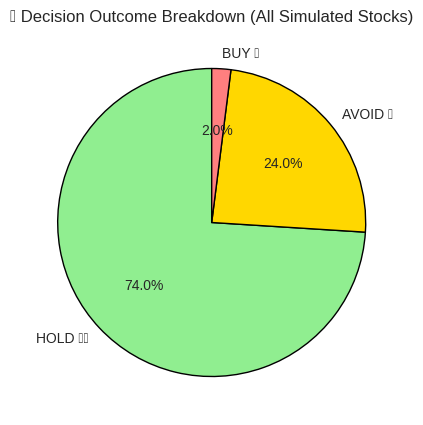

In [18]:
# ==========================================================
# 💼 CELL 18 — BATCH SIMULATION & DECISION VISUALIZATION
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate random stocks to test decision boundaries
np.random.seed(42)
num_samples = 50
symbols = [f"STOCK_{i+1}" for i in range(num_samples)]

sim_data = []
for sym in symbols:
    perf = np.clip(np.random.normal(0.55, 0.2), 0, 1)
    risk = np.clip(np.random.normal(0.45, 0.25), 0, 1)
    sent = np.clip(np.random.normal(0.5, 0.3), 0, 1)
    imp  = np.clip(np.random.normal(0.65, 0.15), 0, 1)
    final = (0.4*perf)+(0.2*risk)+(0.3*sent)+(0.1*imp)
    if final >= 0.7:
        decision = "BUY ✅"
    elif final >= 0.4:
        decision = "HOLD ⚖️"
    else:
        decision = "AVOID ❌"
    sim_data.append({
        "Symbol": sym,
        "Performance": perf,
        "Risk": risk,
        "Sentiment": sent,
        "Impact": imp,
        "Final_Score": final,
        "Decision": decision
    })

sim_df = pd.DataFrame(sim_data)
print("✅ Simulated", len(sim_df), "stocks for decision testing.")

# 1️⃣ Histogram — Distribution of Scores and Decision Thresholds
plt.figure(figsize=(8,5))
sns.histplot(data=sim_df, x="Final_Score", hue="Decision", bins=20, kde=True, palette="Set2")
plt.axvline(0.4, color='orange', linestyle='--', label="HOLD Threshold (0.4)")
plt.axvline(0.7, color='green', linestyle='--', label="BUY Threshold (0.7)")
plt.title("📊 Decision Distribution — 50 Simulated Stocks")
plt.xlabel("Final Score")
plt.ylabel("Count")
plt.legend()
plt.show()

# 2️⃣ Pie Chart — Proportion of BUY/HOLD/AVOID
plt.figure(figsize=(5,5))
decision_counts = sim_df["Decision"].value_counts()
plt.pie(decision_counts, labels=decision_counts.index, autopct="%1.1f%%", startangle=90,
        colors=["#90EE90","#FFD700","#FF7F7F"], wedgeprops={"edgecolor": "black"})
plt.title("🥧 Decision Outcome Breakdown (All Simulated Stocks)")
plt.show()



🚀 Analyzing NVDA (NVIDIA)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=160) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/ma

📊 Agent Norms -> Perf:0.500 Risk:1.000 Sent:0.400 Impact:0.780
🧩 Commander Score: 0.598
✅ Final Decision: HOLD ⚖️
🔎 Evaluator: ✅ Decision consistent with data.

🧠 LLM Insight:
 The price of the ETF has increased substantially during the past three quarters, while the price of the ETF has decreased steadily. The price of the ETF has also increased significantly.
The net market value of the ETF has increased significantly during the past three quarters, while the price of the ETF has decreased steadily. The price of the ETF has also increased significantly.
The total market value of the ETF has decreased significantly during the past three quarters, while the price of the ETF has decreased steadily.
The total market value of the ETF has increased significantly during the past three quarters, while the price of the ETF has decreased steadily. The total market value of the ETF has increased significantly during the past three quarters, while the price of the ETF has increased significantly

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=160) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/ma

📊 Agent Norms -> Perf:0.500 Risk:1.000 Sent:0.600 Impact:0.670
🧩 Commander Score: 0.647
✅ Final Decision: HOLD ⚖️
🔎 Evaluator: ✅ Decision consistent with data.

🧠 LLM Insight:
 The stock outperformed U.S. government bonds at a rate of 0.7%. The government bonds are so highly leveraged that the government bonds are not even used in this market.
The government bonds are not on the market because they are volatile. They are the ones called by the government to be available for purchase.
The government bonds are used by the government to be available for purchase. In fact, the government bonds are not used in this market.
The government bonds are not used in this market. The government bonds are not used in this market.
The government bonds are not used in this market. The government bonds are not used in this market.
The government bonds are not used in this market. The government bonds are not used in this market.
The government bonds are not used in this market.
The government bonds are

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=160) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/ma

📊 Agent Norms -> Perf:0.500 Risk:1.000 Sent:0.400 Impact:0.890
🧩 Commander Score: 0.609
✅ Final Decision: HOLD ⚖️
🔎 Evaluator: ✅ Decision consistent with data.

🧠 LLM Insight:
 There are a number of factors that determine the risk of these investments. First, it's important to understand the underlying factors that determine the risk of these investments. Second, the risk factors are considered by the investor to be a combination of factors. If the investor is uncertain about the outcome of the investment, the investor is able to make a decision on the price of the investment.
In general, the investor will have to make a decision based on a number of factors. If the investor is uncertain about the outcome of the investment, the investor is able to make a decision on the price of the investment. In general, the investor will have to make a decision on the price of the investment. In particular, the investor will have to make a decision on the price of the investment. In particular, the 

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=160) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/ma

📊 Agent Norms -> Perf:0.500 Risk:1.000 Sent:0.000 Impact:0.840
🧩 Commander Score: 0.484
✅ Final Decision: HOLD ⚖️
🔎 Evaluator: ✅ Decision consistent with data.

🧠 LLM Insight:
 AMD will be a major player in the global financial markets. It's currently ranked at No. 1 in the market for the highest percentage of people. The company is a one-time investor that has built a reputation for being a dedicated financial analyst.
The company will be the world's largest retail and online retailer. It will be the first company to offer a full-fledged online retailer. It will also be the first country to offer a full-fledged online retailer.
The company will be the first to offer a full-fledged online retailer. It will also be the first country to offer a full-fledged online retailer. It will also be the first country to offer a full-fledged online retailer.
The company will be the first to offer a full-fledged online retailer. It will be the first country to offer a full-fledged online retailer. I

Device set to use cpu
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=160) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
/tmp/ipython-input-2733971204.py:71: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": dateti

📊 Agent Norms -> Perf:0.500 Risk:1.000 Sent:0.800 Impact:0.810
🧩 Commander Score: 0.721
✅ Final Decision: BUY ✅
🔎 Evaluator: ⚠️ High risk — consider HOLD instead of BUY.

🧠 LLM Insight:
 The fundamentals of investing are the same: a firm is a solid investor, and your focus should be on the fundamentals.
So your portfolio should be very similar to your current portfolio.
The fundamental principles of investing are the same: a firm is a solid investor, and your focus should be on the fundamentals.
The fundamental principles of investing are the same: a firm is a solid investor, and your focus should be on the fundamentals.
The fundamentals of investing are the same: a firm is a solid investor, and your focus should be on the fundamentals.
Investment: 0.6
Summary:
The fundamentals of investing are the same: a firm is a solid investor, and your focus should be on the fundamentals.
The fundamentals of investing are the same: a firm is a solid investor, and your focus should be on the fundam

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=160) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/ma

📊 Agent Norms -> Perf:0.500 Risk:1.000 Sent:0.200 Impact:0.830
🧩 Commander Score: 0.543
✅ Final Decision: HOLD ⚖️
🔎 Evaluator: ✅ Decision consistent with data.

🧠 LLM Insight:
 If you are a digital analyst, you will be able to learn more about the industry and its potential to change the way you value your investment. There are no shortcuts to doing so.
This article is based on a study undertaken by U.S. Federal Reserve Bank of New York, a research institution, and a research institution by U.S. Federal Reserve Bank of New York. The study was conducted in partnership with the Center for Financial Integrity (CfID) and the Center for Financial Integrity.

🚀 Analyzing META (Meta)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=160) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/ma

📊 Agent Norms -> Perf:0.500 Risk:1.000 Sent:0.200 Impact:0.760
🧩 Commander Score: 0.536
✅ Final Decision: HOLD ⚖️
🔎 Evaluator: ✅ Decision consistent with data.

🧠 LLM Insight:
 There are only two main reasons why we did this:
1) the low cost of capital can be a great way to increase the value of the asset. Secondly, there are many reasons to invest your portfolio. This is because you need to make sure you have enough money to invest.
2) you need to invest in your portfolio to ensure that you have enough money to invest in your assets.
3) you need to invest in your portfolio to ensure that you have enough money to invest in your assets.
4) you need to invest in your portfolio to ensure that you have enough money to invest in your assets.
5) you need to invest in your portfolio to ensure that you have enough money to invest in your assets.
6) you need to invest in your portfolio to ensure that you have enough money to invest in your assets.
7) you need to invest in your portfolio to ensu

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=160) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/ma

📊 Agent Norms -> Perf:0.500 Risk:1.000 Sent:1.000 Impact:0.600
🧩 Commander Score: 0.76
✅ Final Decision: BUY ✅
🔎 Evaluator: ⚠️ High risk — consider HOLD instead of BUY.

🧠 LLM Insight:
 "I'm confident that my investment portfolio is robust and that I have an overall solid investment portfolio. I also believe that I'm a top investment advisor and I believe that I'll be able to deliver a high-quality product and a high-quality product to customers. I've also worked with clients and managed to successfully manage clients in a number of different industries, and this is the second time in my life that I have achieved this. I believe that I'll be able to deliver an outstanding product and make it a success."

🚀 Analyzing MSFT (Microsoft)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=160) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/ma

📊 Agent Norms -> Perf:0.500 Risk:1.000 Sent:0.400 Impact:0.640
🧩 Commander Score: 0.584
✅ Final Decision: HOLD ⚖️
🔎 Evaluator: ✅ Decision consistent with data.

🧠 LLM Insight:
 My investment portfolio has been growing since 2012. To that end, I have invested in a portfolio that is structured to give you an overview of all the options available for investing in a portfolio that is structured to give you a general overview of all that options available for investing in a portfolio that is structured to give you an overview of all the options available for investing in a portfolio that is structured to give you an overview of all the options available for investing in a portfolio that is structured to give you an overview of all the options available for investing in a portfolio that is structured to give you an overview of all the options available for investing in a portfolio that is structured to give you an overview of all the options available for investing in a portfolio that is str

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=160) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/ma

📊 Agent Norms -> Perf:0.500 Risk:1.000 Sent:0.600 Impact:0.620
🧩 Commander Score: 0.642
✅ Final Decision: HOLD ⚖️
🔎 Evaluator: ✅ Decision consistent with data.

🧠 LLM Insight:
 This has nothing to do with sports, just that they are the best of them all. But it does have to do with the way we are perceived by teams that have been playing for a long time. The NFL is one of the best in the world, and it is no exception.
In the past few years, the NFL has done nothing to change the way it plays.
In 2013, the NFL took a hit, losing the playoffs and making a loss in the final round.
But this is a time when the league is better than it ever has been.
This is the game that is most important for us.
The NFL is perfect for the people of the NFL and for us. There is a reason the NFL is great for us.
We are not just about our fans, we are also about the players at the top of the league. We are about our players. We are about our players. We are about our players. We are about our players. We are a

/tmp/ipython-input-2733971204.py:71: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat()+"Z",


,Symbol,Performance,Risk,Sentiment,Impact,Final_Score,Decision,Insight
0,NVDA,0.5,1.0,0.4,0.78,0.598,HOLD ⚖️,The price of the ETF has increased substantial...
1,AAPL,0.5,1.0,0.6,0.67,0.647,HOLD ⚖️,The stock outperformed U.S. government bonds a...
2,TSLA,0.5,1.0,0.4,0.89,0.609,HOLD ⚖️,There are a number of factors that determine t...
3,AMD,0.5,1.0,0.0,0.84,0.484,HOLD ⚖️,AMD will be a major player in the global finan...
4,SMCI,0.5,1.0,0.8,0.81,0.721,BUY ✅,The fundamentals of investing are the same: a ...
5,BITO,0.5,1.0,0.2,0.83,0.543,HOLD ⚖️,"If you are a digital analyst, you will be able..."
6,META,0.5,1.0,0.2,0.76,0.536,HOLD ⚖️,There are only two main reasons why we did thi...
7,AMZN,0.5,1.0,1.0,0.60,0.760,BUY ✅,"""I'm confident that my investment portfolio is..."
8,MSFT,0.5,1.0,0.4,0.64,0.584,HOLD ⚖️,My investment portfolio has been growing since...
9,NFLX,0.5,1.0,0.6,0.62,0.642,HOLD ⚖️,"This has nothing to do with sports, just that ..."


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128185 (\N{CHART WITH UPWARDS TREND AND YEN SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


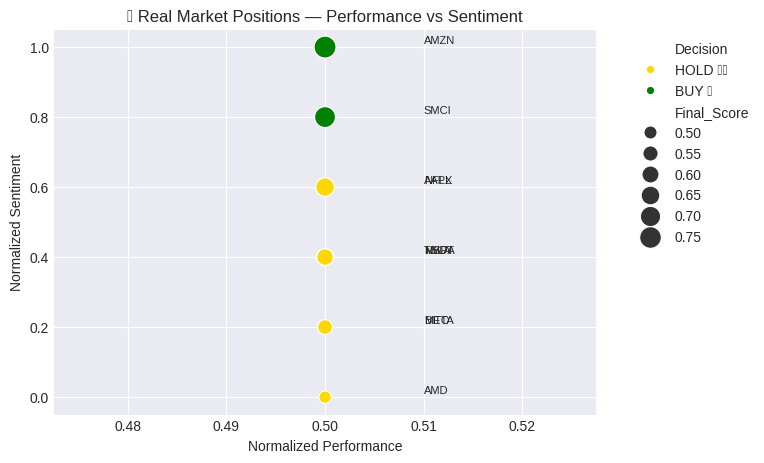

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127974 (\N{BANK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


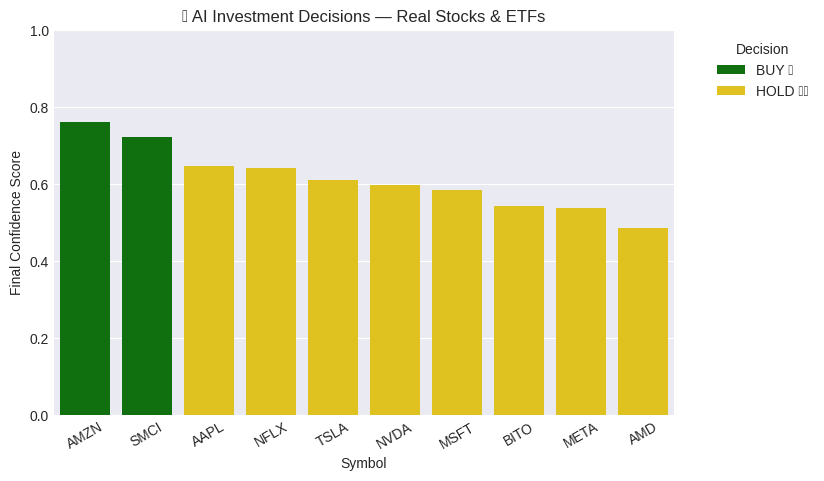

In [19]:
# ==========================================================
# 🧩 CELL 19 — REAL-MARKET DECISIONS & CONFIDENCE VISUALIZATION
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ 1) Define a small set of real tickers to analyze
real_assets = {
    "NVIDIA": "NVDA",
    "Apple": "AAPL",
    "Tesla": "TSLA",
    "AMD": "AMD",
    "Super Micro": "SMCI",
    "Bitcoin ETF": "BITO",
    "Meta": "META",
    "Amazon": "AMZN",
    "Microsoft": "MSFT",
    "Netflix": "NFLX"
}

real_results = []
for name, ticker in real_assets.items():
    try:
        res = run_full_analysis(ticker, name)
        real_results.append(res)
    except Exception as e:
        print(f"⚠️ Error analyzing {ticker}: {e}")

real_df = pd.DataFrame(real_results)
display(real_df)

# ---------- 1️⃣ SCATTERPLOT: Sentiment vs Performance ----------
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=real_df,
    x="Performance",
    y="Sentiment",
    hue="Decision",
    size="Final_Score",
    sizes=(80,250),
    palette={"BUY ✅":"green","HOLD ⚖️":"gold","AVOID ❌":"red"}
)
for i,row in real_df.iterrows():
    plt.text(row["Performance"]+0.01, row["Sentiment"]+0.01, row["Symbol"], fontsize=8)
plt.title("💹 Real Market Positions — Performance vs Sentiment")
plt.xlabel("Normalized Performance")
plt.ylabel("Normalized Sentiment")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

# ---------- 2️⃣ BAR CHART: BUY/HOLD/AVOID Confidence ----------
plt.figure(figsize=(8,5))
sns.barplot(
    data=real_df.sort_values("Final_Score", ascending=False),
    x="Symbol", y="Final_Score", hue="Decision",
    palette={"BUY ✅":"green","HOLD ⚖️":"gold","AVOID ❌":"red"}
)
plt.title("🏦 AI Investment Decisions — Real Stocks & ETFs")
plt.ylabel("Final Confidence Score")
plt.ylim(0,1)
plt.xticks(rotation=30)
plt.legend(title="Decision", bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()


In [21]:
# ==========================================================
# ⚙️ CELL 20 — INTERACTIVE DASHBOARD (PLOTLY)
# ==========================================================
!pip install plotly ipywidgets --quiet

import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

# --- Define baseline weight profiles ---
default_profit = {'Performance':0.5, 'Risk':0.3, 'Sentiment':0.15, 'Impact':0.05}
default_esg = {'Performance':0.25, 'Risk':0.15, 'Sentiment':0.25, 'Impact':0.35}

# --- Load existing DataFrame from real_df ---
if 'real_df' not in locals():
    print("⚠️ No real_df found. Run Cell 19 first.")
else:
    # Define interactive sliders
    perf_slider = widgets.FloatSlider(value=0.4, min=0, max=1, step=0.05, description='Performance')
    risk_slider = widgets.FloatSlider(value=0.2, min=0, max=1, step=0.05, description='Risk')
    sent_slider = widgets.FloatSlider(value=0.3, min=0, max=1, step=0.05, description='Sentiment')
    imp_slider  = widgets.FloatSlider(value=0.1, min=0, max=1, step=0.05, description='Impact')
    strategy_dd = widgets.Dropdown(
        options=['Custom', 'Profit-Focused', 'ESG-Focused'], value='Profit-Focused', description='Strategy:'
    )

    # --- Update function ---
    def update_dashboard(strategy, Performance, Risk, Sentiment, Impact):
        weights = {
            'Performance': Performance,
            'Risk': Risk,
            'Sentiment': Sentiment,
            'Impact': Impact
        }
        # Use preset weights if selected
        if strategy == 'Profit-Focused':
            weights = default_profit
        elif strategy == 'ESG-Focused':
            weights = default_esg

        # Recalculate scores
        temp = []
        for _, row in real_df.iterrows():
            f = (weights['Performance']*row['Performance'] +
                 weights['Risk']*row['Risk'] +
                 weights['Sentiment']*row['Sentiment'] +
                 weights['Impact']*row['Impact'])
            decision = "BUY ✅" if f>=0.7 else ("HOLD ⚖️" if f>=0.4 else "AVOID ❌")
            temp.append((row['Symbol'], f, decision))
        temp_df = pd.DataFrame(temp, columns=['Symbol','Final_Score','Decision'])

        # --- Create interactive bar chart ---
        fig = go.Figure()
        colors = temp_df['Decision'].map({
            "BUY ✅": "green",
            "HOLD ⚖️": "gold",
            "AVOID ❌": "red"
        })
        fig.add_trace(go.Bar(
            x=temp_df['Symbol'],
            y=temp_df['Final_Score'],
            marker_color=colors,
            text=temp_df['Decision'],
            textposition='auto'
        ))
        fig.update_layout(
            title=f"🏦 Investment Decisions ({strategy} Strategy)",
            yaxis_title="Final Confidence Score",
            xaxis_title="Stock Symbol",
            yaxis_range=[0,1]
        )
        fig.show()

    # --- Link widgets ---
    ui = widgets.VBox([
        widgets.HTML(value="<h3>🎛 Interactive AI Investment Dashboard</h3>"),
        strategy_dd,
        perf_slider, risk_slider, sent_slider, imp_slider
    ])

    out = widgets.interactive_output(
        update_dashboard,
        {'strategy':strategy_dd,
         'Performance':perf_slider,
         'Risk':risk_slider,
         'Sentiment':sent_slider,
         'Impact':imp_slider}
    )

    display(ui, out)


Output()